In [6]:
import sys; sys.path.append("..")
from utils import count_down

.
# Analyzing data with Pandas
or
# Special data types, pivot tables and time series in Pandas

In [100]:
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data Types

## Finding the right data types
Data can be expressed in several levels of measurement. You need to make sure to find the level of measurement that both semantically and computationally makes sense.

A quick detour to scales of measurement
1. **Nominal level** <br/>
   Numbers only represent categories and nothing more. <br/>
   E.g.: genders, colors<br/>
   You can compute: absolute and relative frequencies, mode   
   
1. **Ordinal level** <br/>
   The order has a meaning.<br/>
   E.g.: school-grades, music charts, answers on a likert scale <br/>
   You can additionally compute: cumulative frequencies, median, quantiles   
   
1. **Interval level** <br/>
   Same intervals should convey same meaning.<br/>
   E.g.: temperature in celsius, (intelligence) tests<br/>
   You can additionally compute: mean, standard deviation   

1. **Ratio level**<br/>
   Ratios convey meaning and there is a specific 0 point.<br/>
   E.g.: mass, size, time, speed<br/>
   You can compute: coefficient of variation $c = \frac{s}{\bar X}$, i.e. a normalized standard variation 


## Categorical data
https://pandas.pydata.org/pandas-docs/stable/categorical.html

Using a categorical dtype has several advantages

* it keeps memory usage low
* it makes data useable for numeric modeling algorithms
* it signals to libraries that build on pandas how to treat the data
* it makes the intent clear, that only certain values are allowed in a column and how they relate to each other

The following `Series` could be perfectly represented using categories instead of strings.

In [2]:
s = pd.Series(['a','b', 'b', 'a', 'c', 'c'])
s

0    a
1    b
2    b
3    a
4    c
5    c
dtype: object

In [3]:
print(f'The string series is {s.nbytes} bytes big.')

The string series is 48 bytes big.


By specifying the `dtype` as "category" the data is automatically converted to a categorical scale.

In [4]:
s = pd.Series(['a','b', 'b', 'a', 'c', 'c'], dtype='category')
s

0    a
1    b
2    b
3    a
4    c
5    c
dtype: category
Categories (3, object): [a, b, c]

In fact the `Series` gets much smaller already. The effect will be stronger on larger `Series`.

In [5]:
print(f'The categorical series is {s.nbytes} bytes big.')

The categorical series is 30 bytes big.


Categorical data is stored using numeric codes under the hood that map to categories.

In [6]:
s.cat.categories

Index(['a', 'b', 'c'], dtype='object')

In [7]:
s.cat.codes

0    0
1    1
2    1
3    0
4    2
5    2
dtype: int8

Using `dtype='category'` will create unordered categories by default.

In [8]:
s.cat.ordered

False

The `.cat` accessor allows changing, renaming and ordering categories.

In [9]:
s.cat.rename_categories(['x', 'y', 'z'])

0    x
1    y
2    y
3    x
4    z
5    z
dtype: category
Categories (3, object): [x, y, z]

A categorical series can also be created from `pd.Categorical`. This allows you set the categories and the ordering explicitly.

In [10]:
pd.Categorical(['a', 'b', 'c', 'a'], categories=['b', 'c'],
                         ordered=False)

[NaN, b, c, NaN]
Categories (2, object): [b, c]

The `Categorical` object can then be passed to the `Series` constructor to obtain a real `Series`.

In [11]:
cat_series = pd.Series(
    pd.Categorical(['a', 'b', 'c', 'a'], categories=['b', 'c', 'a'],
                         ordered=False)
)
cat_series

0    a
1    b
2    c
3    a
dtype: category
Categories (3, object): [b, c, a]

### Ordered Categories
What does it mean to have ordered categories?

In [12]:
cat_series2 = pd.Series(
    pd.Categorical(['c', 'a', 'c', 'b'], categories=['b', 'c', 'a'],
                         ordered=False)
)
cat_series2

0    c
1    a
2    c
3    b
dtype: category
Categories (3, object): [b, c, a]

In [13]:
cat_series == cat_series2

0    False
1    False
2     True
3    False
dtype: bool

In [14]:
cat_series > cat_series2

TypeError: Unordered Categoricals can only compare equality or not

In [15]:
cat_series.mode()

0    a
dtype: category
Categories (3, object): [b, c, a]

In [16]:
cat_series.max()

TypeError: Categorical is not ordered for operation max
you can use .as_ordered() to change the Categorical to an ordered one


These semantics are lost when you pull out the atomic values. Only the `Series` is categorical, not the single entries.

In [17]:
cat_series.iloc[0] < cat_series.iloc[1]

True

Now the same for an **ordered** cateogorical `Series`.

In [18]:
cat_ordered_series = pd.Series(
    pd.Categorical(['a', 'b', 'c', 'a'], categories=['b', 'c', 'a'],
                         ordered=True)
)
cat_ordered_series

0    a
1    b
2    c
3    a
dtype: category
Categories (3, object): [b < c < a]

In [19]:
cat_ordered_series2 = pd.Series(
    pd.Categorical(['c', 'a', 'c', 'b'], categories=['b', 'c', 'a'],
                    ordered=True)
)
cat_ordered_series2

0    c
1    a
2    c
3    b
dtype: category
Categories (3, object): [b < c < a]

In [20]:
cat_ordered_series > cat_ordered_series2

0     True
1    False
2    False
3     True
dtype: bool

In [21]:
cat_ordered_series.max()

'a'

In [22]:
cat_ordered_series.equals(cat_ordered_series2)

False

The median does still not work right now, but if you really need to you can compute it from the codes.

In [23]:
cat_ordered_series.cat.codes.median()

1.5

If you need to cast existing data, to a categorical type and want to specify the categories and the ordering you can use `pd.CategoricalDtype` to create your own categorical datatype. It works the same way as `pd.Categorical` except that you do not pass the data. The newly created datatype can then be used in an `.astype` cast.

In [24]:
series = pd.Series(['a', 'b', 'c', 'a'])
series

0    a
1    b
2    c
3    a
dtype: object

In [25]:
from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=['b', 'c', 'a'],
                             ordered=True)
cat_type

CategoricalDtype(categories=['b', 'c', 'a'], ordered=True)

In [26]:
series.astype(cat_type)

0    a
1    b
2    c
3    a
dtype: category
Categories (3, object): [b < c < a]

Now let's look at a real world dataset and some discretization techniques. The titanic dataset contains features about passengers of the tragic Titanic journey. A common introductory machine learning excercise is to predict survial of the passengers based on the features (see https://www.kaggle.com/c/titanic/data ).

In [3]:
titanic = pd.read_csv('data/titanic.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [28]:
titanic.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

We include all columns in the description as `object` columns are described differently than `numeric` columns and are excluded from the description by default.

In [29]:
titanic.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Newell, Mr. Arthur Webster",male,NaN,NaN,NaN,CA. 2343,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


Let's extend the port of embarkation with the full name to make things a bit more readable. We use a simple merge operation to achieve this.  

In [30]:
embarked_map = pd.DataFrame({'Embarked': ['C', 'Q', 'S'],
                             'EmbarkedLong': ['Cherbourg', 'Queenstown', 'Southampton']})
embarked_map

,Embarked,EmbarkedLong
0,C,Cherbourg
1,Q,Queenstown
2,S,Southampton


In [31]:
titanic = titanic.merge(embarked_map).sort_values(by='PassengerId')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,EmbarkedLong
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Southampton
644,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cherbourg
1,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Southampton
2,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Southampton
3,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Southampton


In [32]:
titanic.dtypes

PassengerId       int64
Survived          int64
Pclass            int64
Name             object
Sex              object
Age             float64
SibSp             int64
Parch             int64
Ticket           object
Fare            float64
Cabin            object
Embarked         object
EmbarkedLong     object
dtype: object

Since the `EmbarkedLong` column has only three distinct values it is naural to represent it using categories.

In [33]:
titanic['EmbarkedLong'].unique()

array(['Southampton', 'Cherbourg', 'Queenstown'], dtype=object)

In [34]:
titanic['EmbarkedLong'] = titanic['EmbarkedLong'].astype('category')
titanic['EmbarkedLong'].head()

0      Southampton
644      Cherbourg
1      Southampton
2      Southampton
3      Southampton
Name: EmbarkedLong, dtype: category
Categories (3, object): [Cherbourg, Queenstown, Southampton]

In [35]:
titanic.dtypes

PassengerId        int64
Survived           int64
Pclass             int64
Name              object
Sex               object
Age              float64
SibSp              int64
Parch              int64
Ticket            object
Fare             float64
Cabin             object
Embarked          object
EmbarkedLong    category
dtype: object

The description for a categorical column is the same as for an `object` column.

In [36]:
titanic['EmbarkedLong'].describe()

count             889
unique              3
top       Southampton
freq              644
Name: EmbarkedLong, dtype: object

### Exercise

Convert the Sex-Column to a category-datatype

In [7]:
count_down(1)

In [10]:
titanic['Sex'] = titanic['Sex'].astype('category')
titanic.dtypes

PassengerId       int64
Survived          int64
Pclass            int64
Name             object
Sex            category
Age             float64
SibSp             int64
Parch             int64
Ticket           object
Fare            float64
Cabin            object
Embarked         object
dtype: object

## Discretizing continuous values (Tiling)
Sometimes it makes sense to convert numeric into categorical data. For example, for some problems the exact age of a person might not matter, but only whether the person is underaged or not. This process of conversion is called tiling.

https://pandas.pydata.org/pandas-docs/stable/basics.html#discretization-and-quantiling

In [38]:
titanic['Age'].describe()

count    712.000000
mean      29.642093
std       14.492933
min        0.420000
25%       20.000000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

Using `cut` we can discretize numeric values.

In [122]:
titanic['Age'].head(7)

0      22.0
644    38.0
1      26.0
2      35.0
3      35.0
812     NaN
4      54.0
Name: Age, dtype: float64

In [39]:
pd.cut(titanic['Age'], bins=3).head(7)

0        (0.34, 26.947]
644    (26.947, 53.473]
1        (0.34, 26.947]
2      (26.947, 53.473]
3      (26.947, 53.473]
812                 NaN
4        (53.473, 80.0]
Name: Age, dtype: category
Categories (3, interval[float64]): [(0.34, 26.947] < (26.947, 53.473] < (53.473, 80.0]]

By default `cut` will split the data into equally sized intervals. As this seldomly makes sense, we can set the bin edges ourself.

In [40]:
pd.cut(titanic['Age'], bins=[0, 17, 67, 80], include_lowest=True).head(7)

0      (17.0, 67.0]
644    (17.0, 67.0]
1      (17.0, 67.0]
2      (17.0, 67.0]
3      (17.0, 67.0]
812             NaN
4      (17.0, 67.0]
Name: Age, dtype: category
Categories (3, interval[float64]): [(-0.001, 17.0] < (17.0, 67.0] < (67.0, 80.0]]

In [124]:
pd.cut(titanic['Age'], bins=[0, 17, 67, 80], include_lowest=True).value_counts() #include_lowest only asks for the first interval

(17.0, 67.0]      592
(-0.001, 17.0]    113
(67.0, 80.0]        7
Name: Age, dtype: int64

In [41]:
pd.cut(titanic['Age'], bins=[0, 17, 67, 80]).value_counts()

(17, 67]    592
(0, 17]     113
(67, 80]      7
Name: Age, dtype: int64

If you set the bin edges manually, be sure to cover the whole range as values not falling into an interval will be set to NA.

In [156]:
pd.cut(titanic['Age'], 
       bins=[64, 66, 67, 80],
       labels=['child', 'grown-up', 'senior']).head(7)

0      NaN
644    NaN
1      NaN
2      NaN
3      NaN
812    NaN
4      NaN
Name: Age, dtype: category
Categories (3, object): [child < grown-up < senior]

In [11]:
titanic['Age_coarse'] = pd.cut(titanic['Age'], bins=[0, 17, 67, 80], labels=['child', 'grown-up', 'senior'])

A related function is `qcut`, which cuts at quantiles.

In [43]:
pd.qcut(titanic['Age'], 3).head()

0      (0.419, 23.0]
644     (34.0, 80.0]
1       (23.0, 34.0]
2       (34.0, 80.0]
3       (34.0, 80.0]
Name: Age, dtype: category
Categories (3, interval[float64]): [(0.419, 23.0] < (23.0, 34.0] < (34.0, 80.0]]

To understand `pd.qcut`, let's look at the distribution of the data using pandas plotting tools.

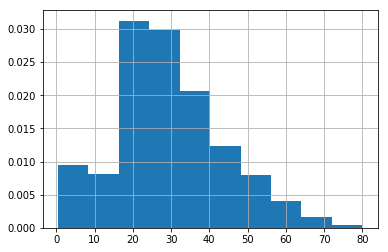

In [44]:
titanic['Age'].hist(density=True)

Pandas plotting tools are in general just calling the corresponding `matplotlib` functions, but are more convenient, as they do not require as to remove NA. Here is the equivalent plot in `matplotlib`. 

(array([0.00953037, 0.00811846, 0.03123844, 0.02982653, 0.02064914,
        0.01235419, 0.00794198, 0.00405923, 0.0015884 , 0.00035298]),
 array([ 0.42 ,  8.378, 16.336, 24.294, 32.252, 40.21 , 48.168, 56.126,
        64.084, 72.042, 80.   ]),
 <a list of 10 Patch objects>)

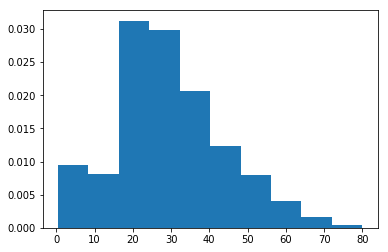

In [45]:
plt.hist(titanic['Age'].dropna().values, density=True)

So `qcut` divides the data into bins such that an equal number of values will fall in each bin. We can also check this visually with Matplotlib (and, more easily, with `seaborn`).

<BarContainer object of 3 artists>

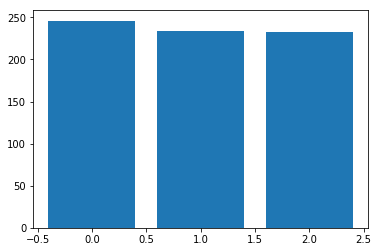

In [46]:
plt.bar(np.arange(3), height=pd.qcut(titanic['Age'], 3).value_counts().values)

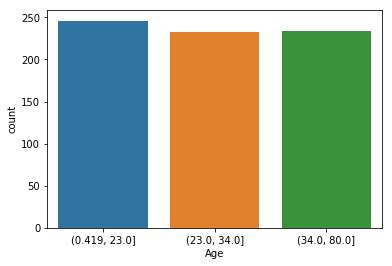

In [47]:
sns.countplot(pd.qcut(titanic['Age'], 3))

In [48]:
age = titanic['Age']
age[(0.4 < age) & (age <= 23)].count() / age.count()

0.3455056179775281

In [49]:
age[(23 < age) & (age <= 34)].count() / age.count()

0.3258426966292135

In [50]:
age[(34 < age) & (age <= 80)].count() / age.count()

0.32865168539325845

## Insertion: Plotting with Pandas

Pandas offers a few Plotting-functions, which base on matplotlib's corresponding functions and internally call these functions themselves. To alter their behaviour, you can pass it an axis to a matplotlib-object: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.hist.html

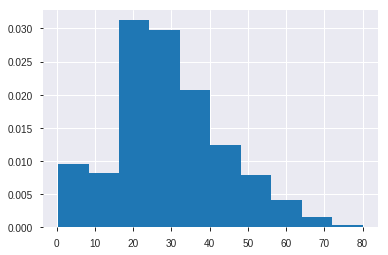

In [141]:
titanic['Age'].hist(density=True)

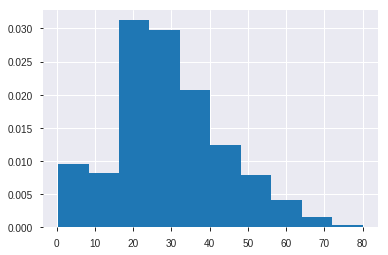

In [147]:
plt.hist(titanic['Age'].dropna().values, density=True);

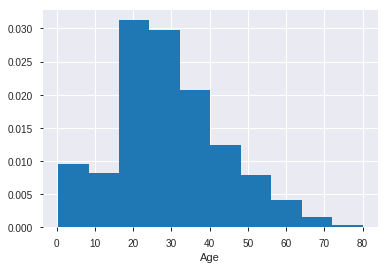

In [146]:
fig, ax = plt.subplots()
ax.hist(titanic['Age'].dropna().values, density=True)
ax.set_xlabel('Age');

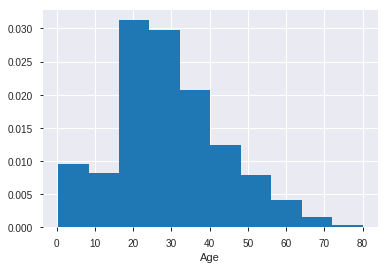

In [150]:
fig, ax = plt.subplots()
titanic['Age'].hist(density=True, ax=ax)
ax.set_xlabel('Age');

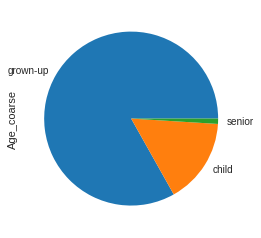

In [218]:
titanic['Age_coarse'].value_counts().plot(kind='pie')

In [219]:
titanic['Age_coarse'] = titanic['Age_coarse'].cat.add_categories(['unknown'])

In [220]:
titanic['Age_coarse'].cat.categories

Index(['child', 'grown-up', 'senior', 'unknown'], dtype='object')

In [221]:
titanic['Age_coarse'] = titanic['Age_coarse'].fillna('unknown')

In [222]:
titanic['Age_coarse'].value_counts()

grown-up    592
unknown     177
child       113
senior        7
Name: Age_coarse, dtype: int64

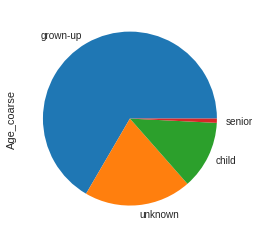

In [223]:
titanic['Age_coarse'].value_counts().plot(kind='pie')

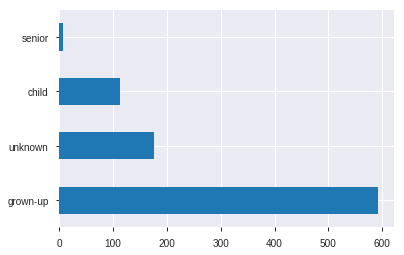

In [224]:
titanic['Age_coarse'].value_counts().plot(kind='barh')

Note that even categories do not prevent you from stupid plots!

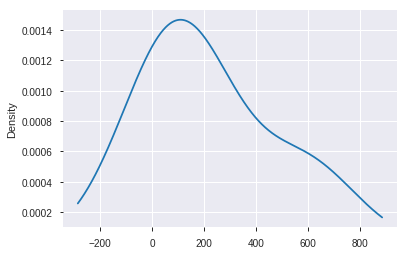

In [231]:
titanic['Age_coarse'].value_counts().plot(kind='kde')

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html

### Exercise
Plot the distribution of males and females in a barplot. Rotate the xticks of the resulting plot by 25° like in the MPL-Homework

In [ ]:
count_down(4)

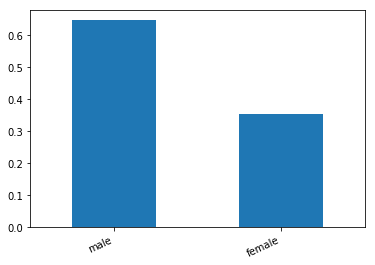

In [37]:
fig, ax = plt.subplots()
(titanic['Sex'].value_counts()/titanic['Sex'].count()).plot(kind='bar', ax=ax)
ax.set_xticklabels(titanic['Sex'], rotation=25, ha='right');

## Converting to numeric data
Sometimes numeric data is srewed up somehow. `pd.numeric` handles these cases, automatically casting everything to the appropriate type.

In [51]:
!cat data/numeric_data.csv

A,B,C
1, 10, 54.8
5, 45, NA
notavailable, 7, 3.7
8,  48.0, 96.0

In [52]:
numeric_data = pd.read_csv('data/numeric_data.csv')
numeric_data

,A,B,C
0,1,10.0,54.8
1,5,45.0,NA
2,notavailable,7.0,3.7
3,8,48.0,96.0


In [53]:
numeric_data.dtypes

A     object
B    float64
C     object
dtype: object

In [54]:
numeric_data['C'].sum()

' 54.8 NA 3.7 96.0'

In [55]:
numeric_data['B'].astype('int')

0    10
1    45
2     7
3    48
Name: B, dtype: int64

In [56]:
numeric_data['A'].astype('float')

ValueError: could not convert string to float: 'notavailable'

In [57]:
pd.to_numeric(numeric_data['A'], errors='coerce')

0    1.0
1    5.0
2    NaN
3    8.0
Name: A, dtype: float64

In [58]:
pd.to_numeric(numeric_data['B'], errors='coerce')

0    10.0
1    45.0
2     7.0
3    48.0
Name: B, dtype: float64

In [59]:
pd.to_numeric(numeric_data['C'], errors='coerce')

0    54.8
1     NaN
2     3.7
3    96.0
Name: C, dtype: float64

to_numeric only works on series, but luckily we can `apply`!

In [236]:
numeric_data.apply(pd.to_numeric, errors='coerce') #keyword-arguments are passed to the respective function

,A,B,C
0,1.0,10.0,54.8
1,5.0,45.0,NaN
2,NaN,7.0,3.7
3,8.0,48.0,96.0


### Optional Integer NA Support

Since Pandas 0.24 (Januar 2019), Pandas can finally hold integer dtypes with missing values:

In [419]:
pd.__version__

'0.24.2'

Remember how annoying a single missing value is for our DataFrame:

In [241]:
exam_data = {
    'name': ['Anastasia', 'Dima', 'Katherine', 'James', 'Emily', 'Michael', 'Matthew', 'Laura', 'Kevin', 'Jonas'],
    'score': [12.5, 9, 16.5, np.nan, 9, 20, 14.5, np.nan, 8, 19],
    'attempts': [1, 3, np.nan, 3, 2, 3, 1, 1, 2, 1],
    }
pd.DataFrame(exam_data)

,name,score,attempts
0,Anastasia,12.5,1.0
1,Dima,9.0,3.0
2,Katherine,16.5,NaN
3,James,NaN,3.0
4,Emily,9.0,2.0
5,Michael,20.0,3.0
6,Matthew,14.5,1.0
7,Laura,NaN,1.0
8,Kevin,8.0,2.0
9,Jonas,19.0,1.0


Pandas can represent integer data with possibly missing values using `arrays.IntegerArray`. This is an extension types implemented within pandas itself, not borrowed from numpy. It is not the default dtype for integers, and will not be inferred; you must explicitly pass the dtype into array() or Series:

In [249]:
tmp = pd.DataFrame(exam_data, dtype='Int8') #dtype=pd.Int8Dtype()
tmp

,name,score,attempts
0,Anastasia,12.5,1
1,Dima,9.0,3
2,Katherine,16.5,NaN
3,James,NaN,3
4,Emily,9.0,2
5,Michael,20.0,3
6,Matthew,14.5,1
7,Laura,NaN,1
8,Kevin,8.0,2
9,Jonas,19.0,1


In [251]:
tmp['attempts'] += 0.01
tmp

,name,score,attempts
0,Anastasia,12.5,1.02
1,Dima,9.0,3.02
2,Katherine,16.5,NaN
3,James,NaN,3.02
4,Emily,9.0,2.02
5,Michael,20.0,3.02
6,Matthew,14.5,1.02
7,Laura,NaN,1.02
8,Kevin,8.0,2.02
9,Jonas,19.0,1.02


Note that this corresponds to a new dtype, the `Nullable Integer Data Type`.

In [254]:
s = pd.Series([1, 2, np.nan], dtype='Int64')
df = pd.DataFrame({'A': s, 'B': [1, 1, 3], 'C': list('aab')})
df

,A,B,C
0,1,1,a
1,2,1,a
2,NaN,3,b


In [256]:
df.dtypes

A     Int64
B     int64
C    object
dtype: object

# Exploratory data analysis

Exploratory data analysis (EDA) describes the process of building up an intuition for our data. It is achieved through a combination of data transformations and visualizations. Typical steps in the process of EDA are:


1. Research the fields of the dataset 
2. Form hypotheses/develop investigation themes to explore 
3. Wrangle data 
3. Assess quality of data 
4. Profile data 
5. Explore each individual variable in the dataset 
6. Assess the relationship between each variable and the target 
7. Assess interactions between variables 
8. Explore data across many dimensions 

EDA is very important as we cannot judge whethe our modeling makes sense if we don't have intuition for our data. While every analysis starts with EDA you will always return to it when you get new results from modeling.

Here we present pivot tables as an easy way to explore the relationships between variables.

## Pivot for analysis 
Last time we introduced pivot tables as a way to restructure untidy data. However, the original are an operation to create tabular summaries of data. They can be used as a convenient shortcut for a two dimensional groupby.

Let's look at a normal groupby first:

In [60]:
titanic.groupby('Sex').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Sex,,,,,,,
female,430.932692,0.740385,2.166667,27.745174,0.698718,0.653846,44.252124
male,454.147314,0.188908,2.389948,30.726645,0.429809,0.235702,25.523893




Let's say we want to analyze the the influnence of gender and passenger class on survial in the titanic dataset.

In [61]:
titanic.groupby(['Sex', 'Pclass'])['Survived'].mean()

Sex     Pclass
female  1         0.967391
        2         0.921053
        3         0.500000
male    1         0.368852
        2         0.157407
        3         0.135447
Name: Survived, dtype: float64

Resetting the index makes it look a little nicer.

In [62]:
titanic.groupby(['Sex', 'Pclass'])['Survived'].mean().reset_index()

,Sex,Pclass,Survived
0,female,1,0.967391
1,female,2,0.921053
2,female,3,0.500000
3,male,1,0.368852
4,male,2,0.157407
5,male,3,0.135447


For people being used to the tidy format, this can in read intuitively. However, you might still prefer have the second variable in the column headers. This is what is called a "pivot table".

In [63]:
titanic.groupby(['Sex', 'Pclass'])['Survived'].mean().unstack()

Pclass,1,2,3
Sex,,,
female,0.967391,0.921053,0.500000
male,0.368852,0.157407,0.135447


For doing exactly this, pandas provides a shortcut.

In [64]:
titanic.pivot_table(values='Survived', index='Sex', columns='Pclass')

Pclass,1,2,3
Sex,,,
female,0.967391,0.921053,0.500000
male,0.368852,0.157407,0.135447


Pivot tables can also include the margins, i.e. the values aggregated over rows and columns.

In [65]:
titanic.pivot_table(values='Survived', index='Sex', columns='Pclass', margins=True)

Pclass,1,2,3,All
Sex,,,,
female,0.967391,0.921053,0.500000,0.740385
male,0.368852,0.157407,0.135447,0.188908
All,0.626168,0.472826,0.242363,0.382452


By default `pivot_table` will aggregate using the mean, but we can also choose all the functions available in `groupby` or use our own ones.

In [66]:
titanic.pivot_table(values='Fare', index='Sex', columns='Pclass',
                   aggfunc=[min, max])

min                   max             
Pclass        1     2     3         1     2      3
Sex                                               
female  25.9292  10.5  6.75  512.3292  65.0  69.55
male     0.0000   0.0  0.00  512.3292  73.5  69.55

We can also aggregate multiple values in the same pivot table.

In [67]:
titanic.pivot_table(index='Sex', columns='Pclass',
                   aggfunc={'Survived': 'sum', 'Fare': 'max'})

Fare              Survived        
Pclass         1     2      3        1   2   3
Sex                                           
female  512.3292  65.0  69.55       89  70  72
male    512.3292  73.5  69.55       45  17  47

Combining more than two variables is equally possible by stacking them in either the rows or the columns.

In [68]:
titanic.pivot_table(values='Fare', index=['Sex', 'EmbarkedLong'], columns='Pclass',
                   aggfunc='mean')

Pclass                        1          2          3
Sex    EmbarkedLong                                  
female Cherbourg     115.640309  25.268457  14.694926
       Queenstown     90.000000  12.350000  10.307833
       Southampton    99.026910  21.912687  18.670077
male   Cherbourg      93.536707  25.421250   9.352237
       Queenstown     90.000000  12.350000  11.924251
       Southampton    52.949947  19.232474  13.307149

In [39]:
titanic['Age_coarse'] = pd.cut(titanic['Age'], bins=[0, 17, 67, 80], labels=['child', 'grown-up', 'senior'])

The tool [`pivottablejs`](https://github.com/nicolaskruchten/pivottable) allows you qickly explore data with pivotables using drag'n'drop. When using such a graphical tool you should make sure that you turn the interesting things into code so they don't get lost after closing the notebook.

In [40]:
from pivottablejs import pivot_ui
pivot_ui(titanic)

### Exercise

Use a pivot-table to check if [Women and children first](https://en.wikipedia.org/wiki/Women_and_children_first) was taken seriously on the Titanic. Is there a difference in the way the tool and Pandas calculate the margins?

In [ ]:
count_down(3)

In [54]:
titanic.pivot_table(values='Survived', index='Age_coarse', columns='Sex', margins=True)

Sex,female,male,All
Age_coarse,,,
child,0.690909,0.396552,0.383838
grown-up,0.771845,0.177835,0.539823
senior,NaN,0.142857,0.142857
All,0.754789,0.205298,0.406162


In [44]:
titanic.groupby('Age_coarse')['Survived'].mean()

Age_coarse
child       0.539823
grown-up    0.383838
senior      0.142857
Name: Survived, dtype: float64

## Profiling
When doing exploratory data analysis a lot have tasks have to be done every time, so they can be automated. Tools like `pandas_profiling` can create summeries that give insights into many standard questions you can ask to a dataset. However, with abstraction comes less flexibility so tools like this will always only do part of your work and might at times not at all do what you want.

In [ ]:
from pandas_profiling import ProfileReport
ProfileReport(titanic)

The following tutorial talks more about tools and processes in exploratory data analysis.

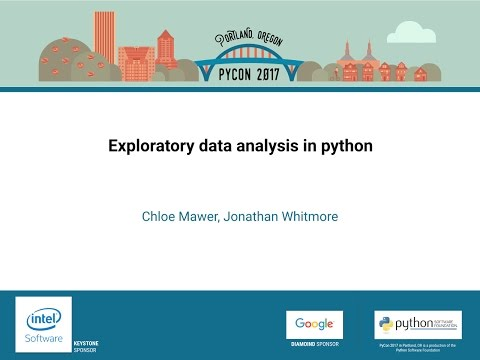

In [71]:
from IPython.display import YouTubeVideo
YouTubeVideo('W5WE9Db2RLU')

# Working with timeseries data
https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html  
The most fundamental building block of timeseries data in pandas is the `Timestamp`. It represents a moment in time to the precision of a nanosecond. It is complemented by `Timedelta`, which represents a stretch of time such as "one month", without being fixed to any date and `Period`, which is a combination of the two such as "June 2018". Yet `Period` needs to have a certain regularity, such as every month.


## Timestamps
Timestamps can be easily created from human readable strings using `pd.datetime`.

In [285]:
pd.to_datetime('2019-06-04')

Timestamp('2019-06-04 00:00:00')

In [286]:
pd.to_datetime('4th June 19')

Timestamp('2019-06-04 00:00:00')

In [287]:
pd.to_datetime('04.06.2019')

Timestamp('2019-04-06 00:00:00')

For non-Americans and people who think that the day should come before the month.

In [288]:
pd.to_datetime('04.06.2019', dayfirst=True)

Timestamp('2019-06-04 00:00:00')

In [289]:
pd.to_datetime('2019-06-04 14:45')

Timestamp('2019-06-04 14:45:00')

In [290]:
date = pd.to_datetime('2019-06-04 14:45:30.600700800')
date

Timestamp('2019-06-04 14:45:30.600700800')

`Timestamps` make all information available via attributes.

In [291]:
date.year

2019

In [292]:
date.month

6

In [293]:
date.day

4

In [294]:
date.second

30

In [295]:
date.microsecond

600700

In [296]:
date.nanosecond

800

When passed a Series, `to_datetime` returns a Series (with the same index), while a list-like is converted to a DatetimeIndex:

In [398]:
pd.to_datetime(pd.Series(['Jul 31, 2009', '2010-01-10', None]))

0   2009-07-31
1   2010-01-10
2          NaT
dtype: datetime64[ns]

In [399]:
pd.to_datetime(['2005/11/23', '2010.12.31'])

DatetimeIndex(['2005-11-23', '2010-12-31'], dtype='datetime64[ns]', freq=None)

### Timezones

In [368]:
time1 = pd.to_datetime('2019-05-21 13:30:38+00:00')
time2 = datetime.now()
time1 > time2

TypeError: can't compare offset-naive and offset-aware datetimes

In [369]:
time1 = pd.to_datetime('2019-05-21 13:30:38')
time2 = datetime.now()
time1 > time2

True

In [370]:
time1 = pd.to_datetime('2019-05-21 13:30:38+00:00')
time1.tz

<UTC>

In [364]:
datetime.now().tzinfo

In [365]:
import pytz
datetime.now(pytz.timezone('Europe/Berlin')).tzinfo

<DstTzInfo 'Europe/Berlin' CEST+2:00:00 DST>

In [373]:
time1 = pd.to_datetime('2019-05-21 08:30:38+00:00')
time2 = datetime.now(pytz.timezone('Europe/Berlin'))
time1 > time2

True

In [374]:
time1 = time1.tz_convert('Europe/Berlin')
time1

Timestamp('2019-05-21 10:30:38+0200', tz='Europe/Berlin')

In [384]:
time1 = pd.to_datetime('2019-05-21 08:30:38', utc=True).tz_convert('Europe/Berlin')
time1

Timestamp('2019-05-21 10:30:38+0200', tz='Europe/Berlin')

In [385]:
time1 = pd.to_datetime('2019-05-21 08:30:38', utc=True).tz_localize('Europe/Berlin')

TypeError: Cannot localize tz-aware Timestamp, use tz_convert for conversions

In [386]:
time1 = pd.to_datetime('2019-05-21 08:30:38').tz_localize('Europe/Berlin')
time1

Timestamp('2019-05-21 08:30:38+0200', tz='Europe/Berlin')

In [387]:
time2 = datetime.now(pytz.timezone('Europe/Berlin'))
time1 > time2

False

In [60]:
start = pd.to_datetime('2015-02-24')
rng = pd.date_range(start, periods=4)

df = pd.DataFrame({'Date': rng, 'a': range(4)})  
df

,Date,a
0,2015-02-24,0
1,2015-02-25,1
2,2015-02-26,2
3,2015-02-27,3


In [62]:
df.Date = df.Date.dt.tz_localize('UTC').dt.tz_convert('Asia/Kolkata') #just like there's a .str-accessor for strings, there's a .dt-accessor for datetimes
df

,Date,a
0,2015-02-24 05:30:00+05:30,0
1,2015-02-25 05:30:00+05:30,1
2,2015-02-26 05:30:00+05:30,2
3,2015-02-27 05:30:00+05:30,3


### Datetime Compatibility

For those of you used to thinking in unix-time (https://www.unixtimestamp.com/):

In [297]:
pd.to_datetime('2019-06-04').value

1528070400000000000

In [299]:
import time
time.mktime(pd.to_datetime('2019-06-04').timetuple())

1559599200.0

`Timestamps` can be formatted using a special set of symbols. All of them can be found here https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior

In [84]:
date.strftime('Today is %A')

'Today is Monday'

In [401]:
pd.to_datetime('12-11-2010 00:00', format='%d-%m-%Y %H:%M')

Timestamp('2010-11-12 00:00:00')

### Exercise 

Write a function that recieves a datetime and shows a text like `That day is Tuesday, the 21st of May 2019`

In [85]:
from datetime import datetime

SUFFIXES = {1: 'st', 2: 'nd', 3: 'rd'}
def ordinal(num):
    if 10 <= num % 100 <= 20:
        suffix = 'th'
    else:
        suffix = SUFFIXES.get(num % 10, 'th')
    return str(num) + suffix

tell_day(datetime.now())

That day is Tuesday, the 21st of May 2019


In [ ]:
count_down(4)

In [84]:
def tell_day(dt):
    print(dt.strftime('That day is %A, the'), ordinal(int(dt.strftime('%d'))), dt.strftime('of %B %Y'))

### DatetimeIndex

Timestamps can be used to index data.

In [328]:
index = pd.DatetimeIndex(['2018-06-04', '2018-06-11',
                          '2018-06-18', '2018-06-25',
                          '2018-06-02'])
schedule = pd.Series(['Analyzing Data with Pandas', 'Creating Experiments', 
                      'Statistical Modeling', 'Statistical Visualization',
                  'Interactive Plotting'], index=index)
schedule

2018-06-04    Analyzing Data with Pandas
2018-06-11          Creating Experiments
2018-06-18          Statistical Modeling
2018-06-25     Statistical Visualization
2018-06-02          Interactive Plotting
dtype: object

In [329]:
schedule['2018-06-10':'2018-06-30']

2018-06-11         Creating Experiments
2018-06-18         Statistical Modeling
2018-06-25    Statistical Visualization
dtype: object

In [403]:
pd.to_datetime(['2009/07/31', 'asd'], errors='coerce')

DatetimeIndex(['2009-07-31', 'NaT'], dtype='datetime64[ns]', freq=None)

## Timedeltas and Periods

Timedeltas can be added to Timestamps

In [330]:
delta = pd.to_timedelta('1 day')
delta

Timedelta('1 days 00:00:00')

In [331]:
schedule.index += delta
schedule

2018-06-05    Analyzing Data with Pandas
2018-06-12          Creating Experiments
2018-06-19          Statistical Modeling
2018-06-26     Statistical Visualization
2018-06-03          Interactive Plotting
dtype: object

In [332]:
from datetime import datetime
datetime.now()

datetime.datetime(2019, 5, 21, 0, 36, 10, 402965)

In [333]:
datetime.now() - pd.to_datetime('2018-06-04')

Timedelta('351 days 00:36:10.866130')

In [334]:
schedule.index += (datetime.now() - pd.to_datetime('2018-06-05'))
schedule.index = schedule.index.date
schedule

2019-05-21    Analyzing Data with Pandas
2019-05-28          Creating Experiments
2019-06-04          Statistical Modeling
2019-06-11     Statistical Visualization
2019-05-19          Interactive Plotting
dtype: object

In [417]:
#there are even Businessdays in Pandas (Friday --> Monday)
friday = pd.Timestamp('2018-01-05')
monday = friday + pd.offsets.BDay()
monday

Timestamp('2018-01-08 00:00:00')

A more convenient way to create such an index is to use `date_range`.  
`periods` specifies how many entires we want, alternatively we could set an explicit `stop`. `freq` specifies how the entries are spaced. The full list of possible offsets can be found here http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases. Thus the syntax is very similar to `range(start, stop, step)`

In [89]:
index = pd.date_range('2018-06-04', periods=5, freq='W')
index

DatetimeIndex(['2018-06-10', '2018-06-17', '2018-06-24', '2018-07-01',
               '2018-07-08'],
              dtype='datetime64[ns]', freq='W-SUN')

In [88]:
index = pd.date_range('2018-06-04', periods=5, freq='7D')
index

DatetimeIndex(['2018-06-04', '2018-06-11', '2018-06-18', '2018-06-25',
               '2018-07-02'],
              dtype='datetime64[ns]', freq='7D')

Pandas is smart at inferring frequencies:

In [404]:
tmp = pd.DatetimeIndex(['2018-01-01', '2018-01-03', '2018-01-05'], freq='infer')
tmp

DatetimeIndex(['2018-01-01', '2018-01-03', '2018-01-05'], dtype='datetime64[ns]', freq='2D')

In [410]:
ts = pd.Series(range(len(tmp)), index=tmp)
ts

2018-01-01    0
2018-01-03    1
2018-01-05    2
Freq: 2D, dtype: int64

In [415]:
ts.resample('D').sum().index

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05'],
              dtype='datetime64[ns]', freq='D')

Alternatively we could use a `Period` index to signal that a topic belongs to an entire week.

In [91]:
pd.Period('2018-06-04')

Period('2018-06-04', 'D')

In [86]:
index = pd.period_range('2018-06-04', periods=5, freq='W')
schedule = pd.Series(['Analyzing Data with Pandas', 'Statistical Visualization', 
                  'Statistical Modeling', 'Creating Experiments',
                  'Other tools and libraries'], index=index)
schedule

2018-06-04/2018-06-10    Analyzing Data with Pandas
2018-06-11/2018-06-17     Statistical Visualization
2018-06-18/2018-06-24          Statistical Modeling
2018-06-25/2018-07-01          Creating Experiments
2018-07-02/2018-07-08     Other tools and libraries
Freq: W-SUN, dtype: object

You can easily convert between `Timestamp` and period.

In [93]:
schedule = schedule.to_timestamp()
schedule

2018-06-04    Analyzing Data with Pandas
2018-06-11     Statistical Visualization
2018-06-18          Statistical Modeling
2018-06-25          Creating Experiments
2018-07-02     Other tools and libraries
Freq: W-MON, dtype: object

In [94]:
schedule.to_period(freq='W')

2018-06-04/2018-06-10    Analyzing Data with Pandas
2018-06-11/2018-06-17     Statistical Visualization
2018-06-18/2018-06-24          Statistical Modeling
2018-06-25/2018-07-01          Creating Experiments
2018-07-02/2018-07-08     Other tools and libraries
Freq: W-SUN, dtype: object

### Insertion: Accessing values in Series

In [262]:
idx = pd.period_range('2000', periods=4)
idx

PeriodIndex(['2000-01-01', '2000-01-02', '2000-01-03', '2000-01-04'], dtype='period[D]', freq='D')

For Series and Indexes backed by normal NumPy arrays, Series.array will return a new arrays.PandasArray, which is a thin (no-copy) wrapper around a numpy.ndarray. PandasArray isn’t especially useful on its own, but it does provide the same interface as any extension array defined in pandas or by a third-party library.

In [264]:
idx.array

<PeriodArray>
['2000-01-01', '2000-01-02', '2000-01-03', '2000-01-04']
Length: 4, dtype: period[D]

In [270]:
pd.Series([1, 2, 3]).array

<PandasArray>
[1, 2, 3]
Length: 3, dtype: int64

In [265]:
idx.to_numpy()

array([Period('2000-01-01', 'D'), Period('2000-01-02', 'D'),
       Period('2000-01-03', 'D'), Period('2000-01-04', 'D')], dtype=object)

In [266]:
type(idx.to_numpy()[0])

pandas._libs.tslibs.period.Period

## Reading timeseries data

In [95]:
!head data/ao_monthly.txt

 1950    1  -0.60310E-01
 1950    2   0.62681E+00
 1950    3  -0.81275E-02
 1950    4   0.55510E+00
 1950    5   0.71577E-01
 1950    6   0.53857E+00
 1950    7  -0.80248E+00
 1950    8  -0.85101E+00
 1950    9   0.35797E+00
 1950   10  -0.37890E+00


In [96]:
ts = pd.read_fwf('data/ao_monthly.txt', header=None, index_col=0)
ts.head()

,1,2
0,,
1950,1,-0.060310
1950,2,0.626810
1950,3,-0.008128
1950,4,0.555100
1950,5,0.071577


This creates an integer index instead of the desired `DateTimeIndex`.

In [97]:
ts.index

Int64Index([1950, 1950, 1950, 1950, 1950, 1950, 1950, 1950, 1950, 1950,
            ...
            2015, 2015, 2015, 2015, 2016, 2016, 2016, 2016, 2016, 2016],
           dtype='int64', name=0, length=798)

In [90]:
ts = pd.read_fwf('data/ao_monthly.txt', header=None, index_col=0,
                parse_dates=[[0, 1]], infer_datetime_format=True)
ts.head()

,2
0_1,
1950-01-01,-0.060310
1950-02-01,0.626810
1950-03-01,-0.008128
1950-04-01,0.555100
1950-05-01,0.071577


In [99]:
ts.index

DatetimeIndex(['1950-01-01', '1950-02-01', '1950-03-01', '1950-04-01',
               '1950-05-01', '1950-06-01', '1950-07-01', '1950-08-01',
               '1950-09-01', '1950-10-01',
               ...
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01'],
              dtype='datetime64[ns]', name='0_1', length=798, freq=None)

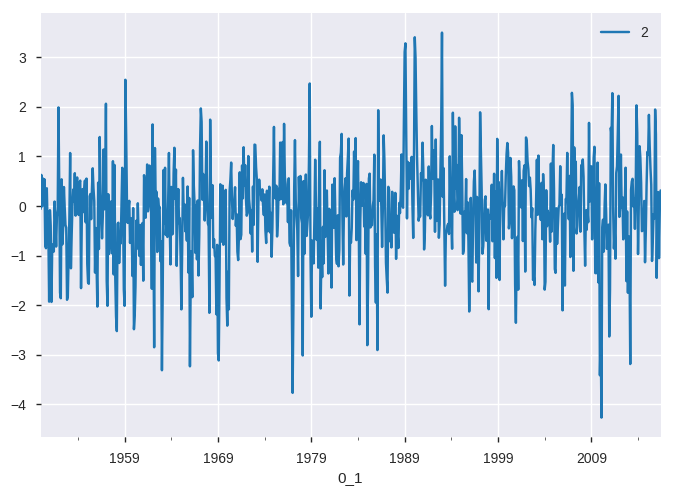

In [100]:
ts.plot()

Now that our series in index by timestamps, we can aggregate using time related semantics.

In [101]:
ts.groupby(ts.index.year).mean().head()

,2
0_1,
1950,-0.199501
1951,-0.364626
1952,-0.674990
1953,-0.016515
1954,-0.000770


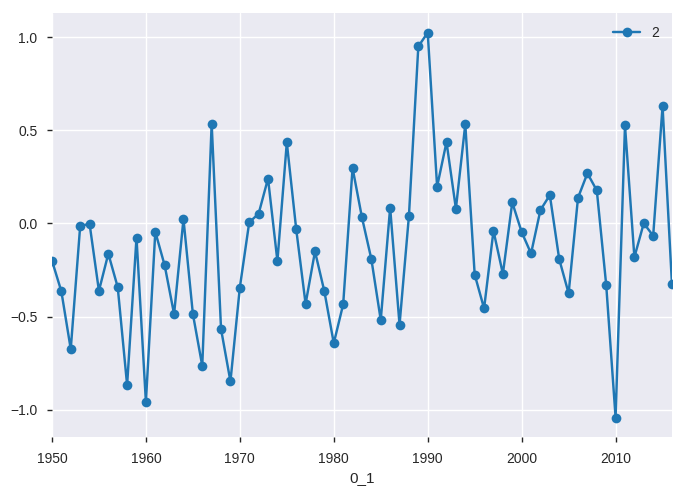

In [102]:
ts.groupby(ts.index.year).mean().plot(marker='o')

Using `pd.Grouper` we can specify more complex groupings.

In [103]:
ts.groupby(pd.Grouper(freq='5Y')).mean().head()

,2
0_1,
1950-12-31,-0.199501
1955-12-31,-0.283744
1960-12-31,-0.481644
1965-12-31,-0.243986
1970-12-31,-0.397825


In [104]:
ts.groupby(pd.Grouper(freq='5Y')).mean().index[0]

Timestamp('1950-12-31 00:00:00', freq='5A-DEC')

In [110]:
ts.groupby(pd.Grouper(freq='5Y')).mean().head()

,2
0_1,
1950-12-31,-0.199501
1955-12-31,-0.283744
1960-12-31,-0.481644
1965-12-31,-0.243986
1970-12-31,-0.397825


In [108]:
ts.groupby(pd.Grouper(freq='d')).mean().head()

,2
0_1,
1950-01-01,-0.06031
1950-01-02,NaN
1950-01-03,NaN
1950-01-04,NaN
1950-01-05,NaN


### Resampling
If you do not like the frequency at which your data is sampled you can change the sampling frequency.

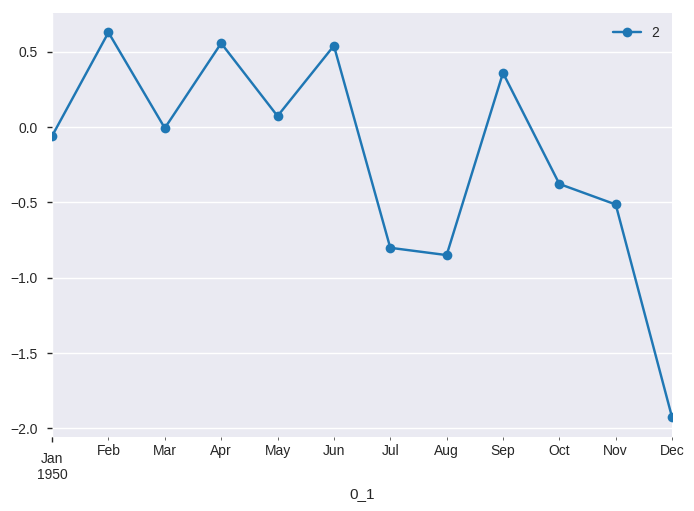

In [106]:
nineteenfifty = ts['1950']
nineteenfifty.plot(marker='o')

In [107]:
nineteenfifty.asfreq('12D', method='ffill').head()

,2
0_1,
1950-01-01,-0.06031
1950-01-13,-0.06031
1950-01-25,-0.06031
1950-02-06,0.62681
1950-02-18,0.62681


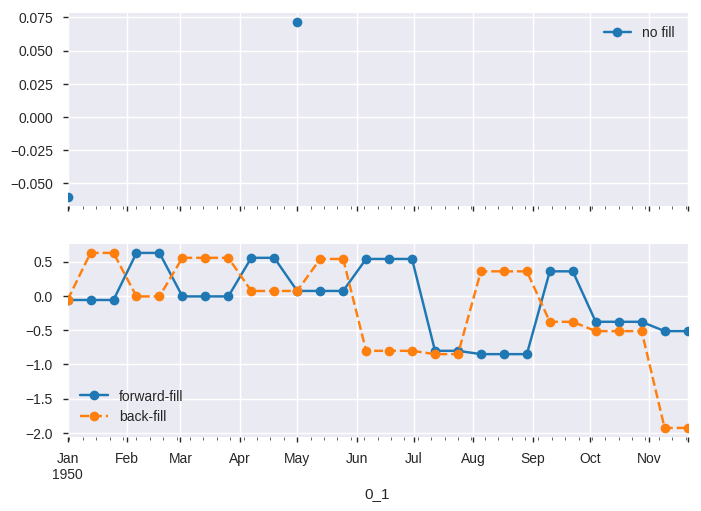

In [108]:
fig, ax = plt.subplots(nrows=2, sharex=True)

nineteenfifty.asfreq('12D').plot(ax=ax[0], style='-o')
nineteenfifty.asfreq('12D', method='ffill').plot(ax=ax[1], marker='o')
nineteenfifty.asfreq('12D', method='bfill').plot(ax=ax[1], style='--o', label='backward')
ax[0].legend(['no fill']);
ax[1].legend(['forward-fill', 'back-fill']);

Downsampling can be done by specifying a smaller frequency.

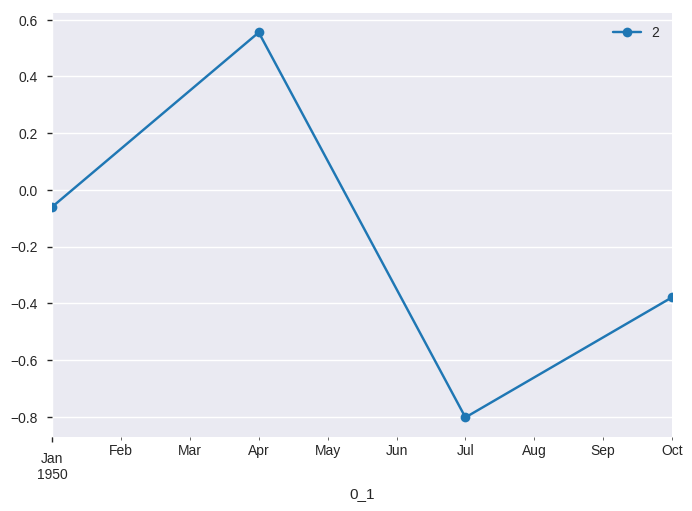

In [109]:
nineteenfifty.asfreq('3M', method='ffill').plot(marker='o')

Resampling can also be combined with aggregation using `resample`.
Let's look at some stock data to illustrate this.

In [110]:
yahoo = pd.read_csv('data/yahoo_stock.csv', index_col=0, parse_dates=True)
yahoo.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-01-02,12.17,12.85,12.12,12.85,12.85,9514600
2009-01-05,12.72,13.01,12.39,12.86,12.86,11989900
2009-01-06,12.96,13.24,12.88,13.00,13.00,10056000
2009-01-07,12.71,13.16,12.45,12.71,12.71,24995900
2009-01-08,12.37,13.07,12.31,13.07,13.07,14355000


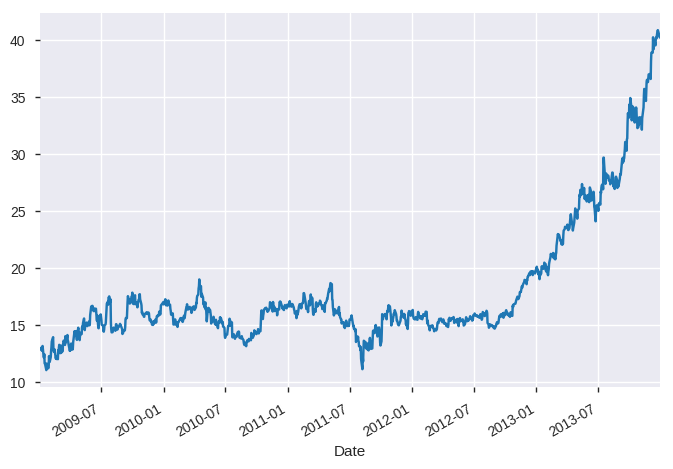

In [111]:
ts = yahoo['Close']
ts.plot()

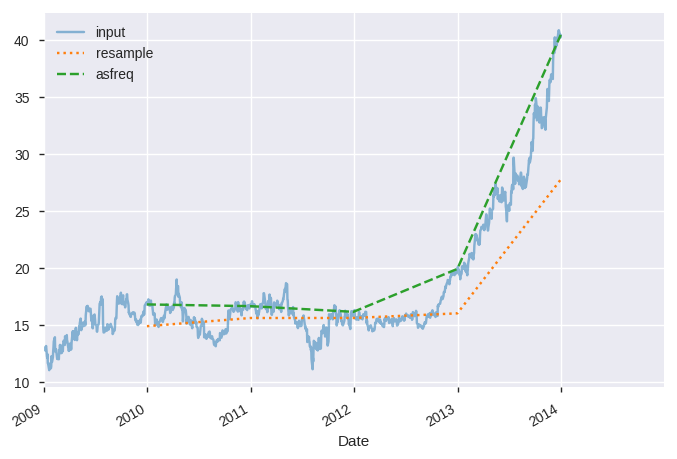

In [112]:
ts.plot(alpha=0.5, style='-')
ts.resample('BA').mean().plot(style=':')
ts.asfreq('BA').plot(style='--');
plt.legend(['input', 'resample', 'asfreq'],
           loc='upper left');

### Shifting and Differencing
Shifting data in time can be done in two ways. `shift` actually moves the data. Creating missing values at the one end and losing data at the other. In contrast, `tshift` only shifts the time index of the data and not the data itself.

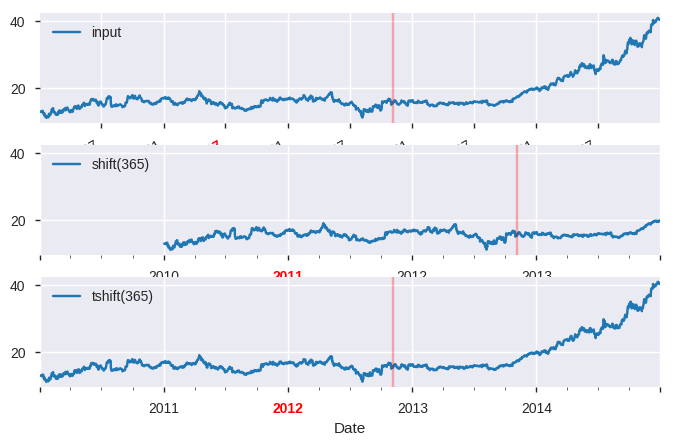

In [113]:
fig, ax = plt.subplots(3, sharey=True)

# apply a frequency to the data
ts_resampled = ts.asfreq('D', method='ffill')

ts.plot(ax=ax[0])
ts_resampled.shift(365).plot(ax=ax[1])
ts_resampled.tshift(365).plot(ax=ax[2])

# legends and annotations
local_max = pd.to_datetime('2011-11-05')
offset = pd.Timedelta(365, 'D')

ax[0].legend(['input'], loc=2)
ax[0].get_xticklabels()[2].set(weight='heavy', color='red')
ax[0].axvline(local_max, alpha=0.3, color='red')

ax[1].legend(['shift(365)'], loc=2)
ax[1].get_xticklabels()[2].set(weight='heavy', color='red')
ax[1].axvline(local_max + offset, alpha=0.3, color='red')

ax[2].legend(['tshift(365)'], loc=2)
ax[2].get_xticklabels()[2].set(weight='heavy', color='red')
ax[2].axvline(local_max + offset, alpha=0.3, color='red');

Shifting is useful for calculations that compare values across timesteps. An example is differencing to remove trend in the timeseries.

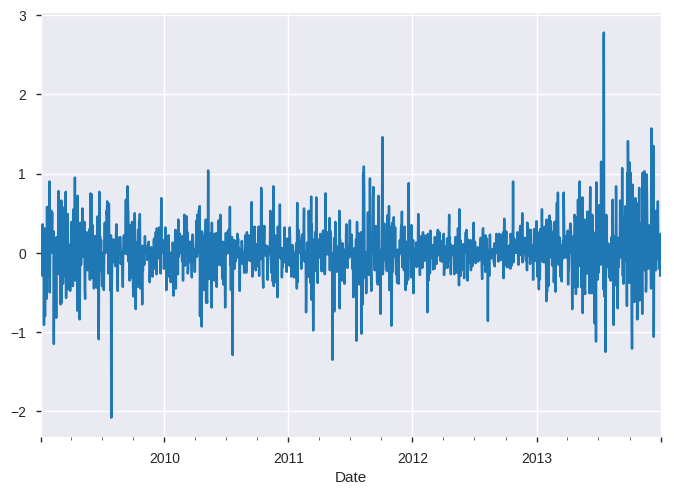

In [114]:
(ts_resampled - ts_resampled.shift(periods=1)).plot()

For differencing, pandas provides the convenient `diff` method.

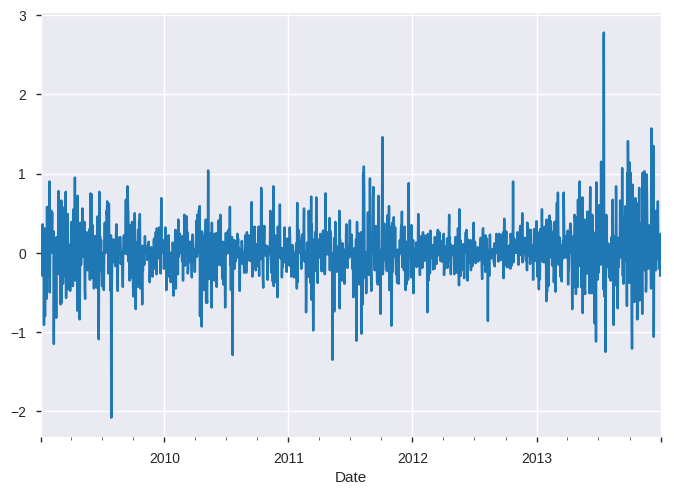

In [115]:
ts_resampled.diff(periods=1).plot()

## Window functions
Window functions are similar to `groupby` as they split data into different groups based on a changing window. The points in each window are aggregated using a summary statistic and then combined back into a timeseries.

### Rolling window
A rolling window is the standard example of a window function. It moves a window of fixed size across the timeseries.

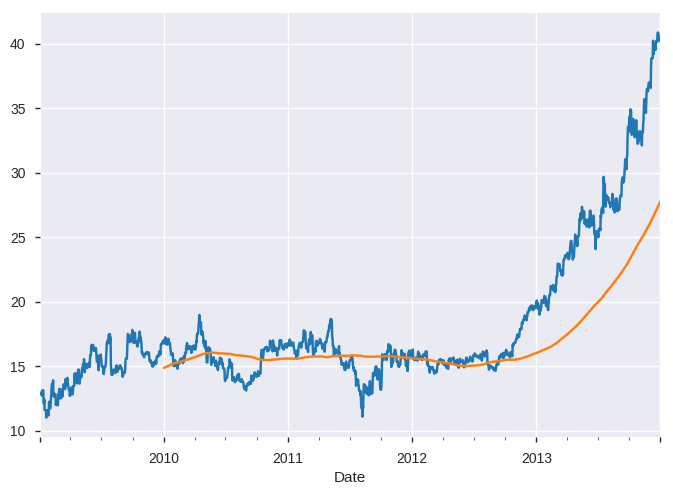

In [116]:
ts_resampled.plot()
ts_resampled.rolling(365).mean().plot()

Setting `center=True` the point that is aggregated and put into the new series will be from the middle of the window and not from its end. 

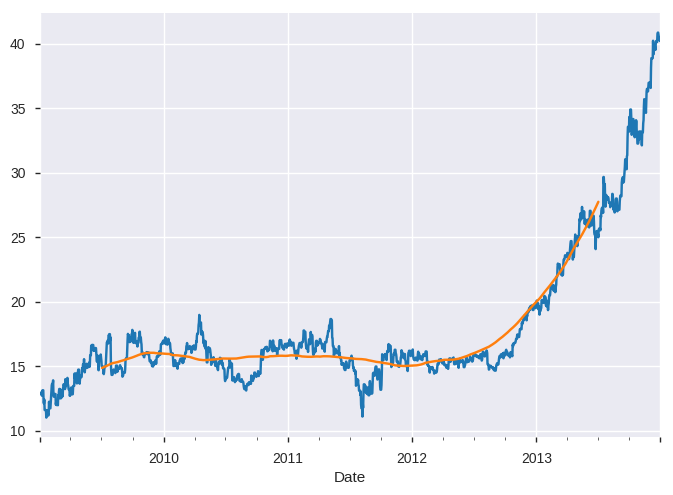

In [117]:
ts_resampled.plot()
ts_resampled.rolling(365, center=True).mean().plot()

### Expanding windows
An expanding window only has a minimal size. Then it grows bigger with each step, taking all previous values into account. This is useful if your timeseries measures a stationary value that only fluctuates around a mean.

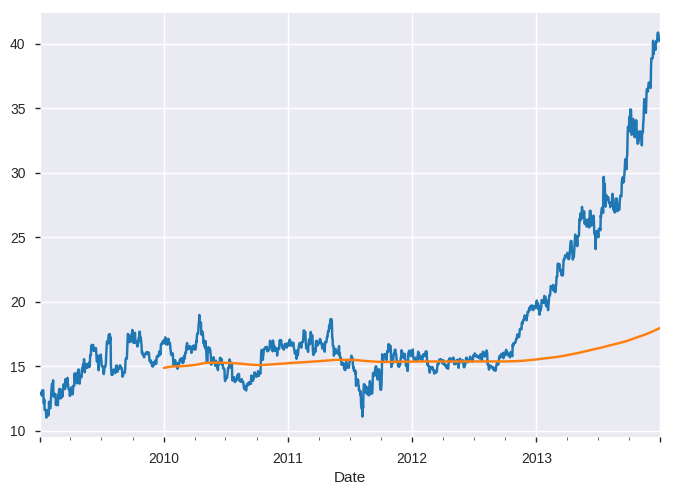

In [118]:
ts_resampled.plot()
ts_resampled.expanding(min_periods=365).mean().plot()

### Exponential weighted windows
An exponential weighted window works like an expanding window, but gives more recent datapoints an exponentially higher weighting in all calculations. Thus it can be viewed as a smooth version of a rolling window.

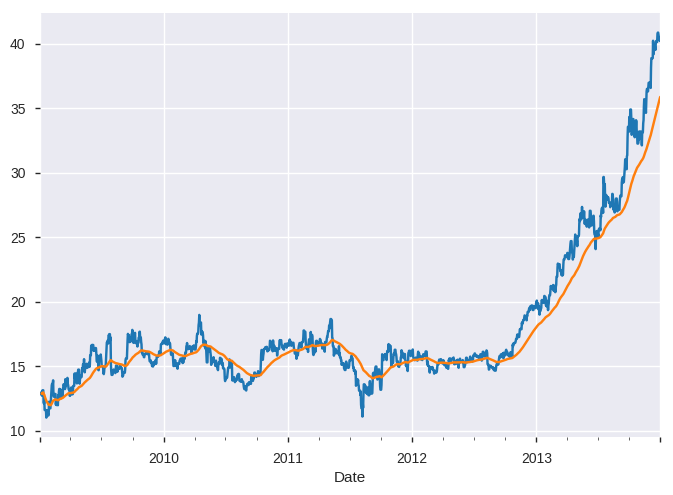

In [119]:
ts_resampled.plot()
ts_resampled.ewm(com=50.5, min_periods=5).mean().plot()

First info regarding anything to do with timeseries: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

Further:  
A complete time series analysis tutorial. It includes handling time zones plus basic time series prediction and classification.

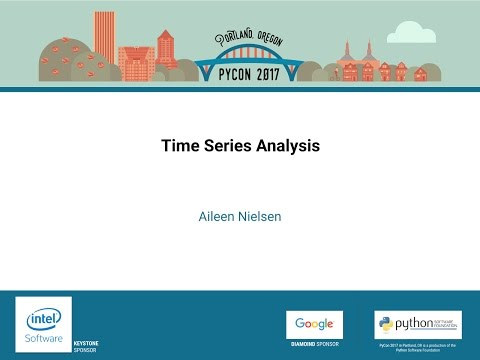

In [120]:
from IPython.display import YouTubeVideo
YouTubeVideo('zmfe2RaX-14')